In [1]:
#%%
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from copy import copy
import os

from tqdm import tqdm
#os.chdir('/Users/daniele/Dropbox/Fisica/2023/EvolvingDensities-main/')

from scipy.interpolate import interp1d, UnivariateSpline, interpn
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.cosmology import Planck18
from evolving_densities import Density, smooth_Bspline
from polytropic import PolytropicSolver
from colourmap_maker import lch_colour_map, luv_colour_map

from timeit import default_timer as timer

rgb_palette = np.array([[255, 97, 229], [241, 0, 123], 
                        [151, 0, 71], [54, 3, 27], 
                        [179, 126, 12], [255, 190, 11], 
                        [250, 237, 185], [86, 235, 215],
                        [0, 128, 117], [0, 59, 59]], dtype = np.float32)/255

rgb_palette_dict = {'purple pizzazz': rgb_palette[0], 'flickr pink': rgb_palette[1],
                    'jazzberry jam': rgb_palette[2], 'dark sienna': rgb_palette[3],
                    'dark goldenrod': rgb_palette[4], 'amber': rgb_palette[5],
                    'blond': rgb_palette[6], 'turquiose': rgb_palette[7],
                    'pine green': rgb_palette[8], 'rich black': rgb_palette[9]}

#%%
import sys
from importlib import reload
reload(sys.modules['evolving_densities'])
from evolving_densities import Density

plt.rcParams.update({
    "text.usetex": False
})

#%%

G_N = 4.302e-3 #Units of (pc/solar mass) (km/s)^2
c_light = 2.9979e05 #km/s
G_N_Mpc = 1e-6*4.302e-3 #(Mpc/solar mass) (km/s)^2

r_array = np.geomspace(1e-10, 1e3, num = 1301)

h = 0.678
Omega_DM = 0.1186/(h**2)
H0 = 100.0*h #(km/s) Mpc^-1
H0_peryr = 67.8*(3.24e-20)*(60*60*24*365)
ageUniverse = 13.799e9 #y
Omega_L = 0.692
Omega_m = 0.308
Omega_r = 9.3e-5

z_eq = 3375.0
rho_eq = 1512.0 #Solar masses per pc^3
sigma_eq = 0.005 #Variance of DM density perturbations at equality
lambda_max = 3.0 #Maximum value of lambda = 3.0*z_dec/z_eq (i.e. binaries decouple all the way up to z_dec = z_eq)

def Hubble(z):
    return H0_peryr*np.sqrt(Omega_L + Omega_m*(1+z)**3 + Omega_r*(1+z)**4)

def Hubble2(z):
    return H0*np.sqrt(Omega_L + Omega_m*(1+z)**3 + Omega_r*(1+z)**4)

rho_critical_today_Mpc = 3.0*H0**2/(8.0*np.pi*G_N_Mpc) #Solar masses per Mpc^3
rho_critical_today = rho_critical_today_Mpc / 1.e18

def rho_critical_Mpc(z):
    return 3.0*Hubble2(z)**2/(8*np.pi*G_N_Mpc) #Solar masses per pc^3

def rho_critical(z):
    return 3.0*Hubble2(z)**2/(8*np.pi*G_N_Mpc*1.e18) #Solar masses per pc^3

print("Critical density today [MSun/pc**3] ", rho_critical(0))


# HALO PARAMETERS *********************************
M_halo = 1.E7
z = 15
## Concentration
c = 3. #https://arxiv.org/pdf/1502.00391.pdf Fig. 7

#R_vir = 1E3 #0.784*(Planck18.Om0/Planck18.Om(15))**(-1/3) * (M_halo*1E-8*Planck18.h)**(1/3) * (10/(z + 1)) / Planck18.h *1E3
## Virial radius in pc
R_vir = (3.*M_halo/(4.*np.pi*200.*rho_critical(z)))**(1./3)  #pc

print("Critical density at z = 15", rho_critical(z), " [Msun/pc**3]")
print("Virial radius at z = 15", R_vir, " [pc]")

Critical density today [MSun/pc**3]  1.275588996364624e-07
Critical density at z = 15 0.00016177490369340906  [Msun/pc**3]
Virial radius at z = 15 419.4273517886672  [pc]


r_poly: 4.446341891734883e-06
>------- NOTE THAT WE'RE USING A FACTOR OF 2 TO FUDGE THE RESULTS: CHECK WHERE IT COMES FROM!
> Creating Density objects...


/var/folders/zr/f2d9jr713t9f5hjyf3917rrm0000gn/T/ipykernel_46568/1516576198.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return rho_0_prime * (R_s/r) / (1 + r/R_s)**2 * np.exp(-r/R_vir)
/var/folders/zr/f2d9jr713t9f5hjyf3917rrm0000gn/T/ipykernel_46568/1516576198.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return rho_0_prime * (R_s/r) / (1 + r/R_s)**2 * np.exp(-r/R_vir)


> ...Done.
> ...Done.
> Creating FIGURE 1...


"\nrho_0_gas_i = 1E-23 * (3.0857E18)**3 / (1.9885E33) # M_sun/pc^3\nr_c_i = 1E1\ndef rho_gas_initial(r):\n    return rho_0_gas_i / (1 + r/r_c_i)**2\n\nrho_0_gas_f = 1E-15 * (3.0857E18)**3 / (1.9885E33) # M_sun/pc^3\nr_c_f = 1E-3\ndef rho_gas_final(r):\n    return rho_0_gas_f / (1 + r/r_c_f)**2\n\nplt.figure()\nplt.loglog(r_array, rho_NFW(r_array), c = rgb_palette_dict['rich black'])\nplt.loglog(r_array, rho_gas_initial(r_array), c = rgb_palette_dict['pine green'])\nplt.loglog(r_array, rho_gas_final(r_array), c = rgb_palette_dict['turquiose'])\nplt.ylim(bottom = 1E-4)\n#plt.show()\n\n#rho_M_data = np.genfromtxt('/Users/daniele/Dropbox/Fisica/2023/EvolvingDensities-main/rho_M.csv', delimiter = ',')\nrho_M_data = np.genfromtxt('rho_M.csv', delimiter = ',')\nlogrho_M_interp = interp1d(rho_M_data[:, 0], np.log10(rho_M_data[:, 1]), kind = 'quadratic', bounds_error = False,\n                           fill_value = (np.log10(rho_M_data[0, 1]), 0))\nrho_M_interp = lambda x: 10**logrho_M_interp(

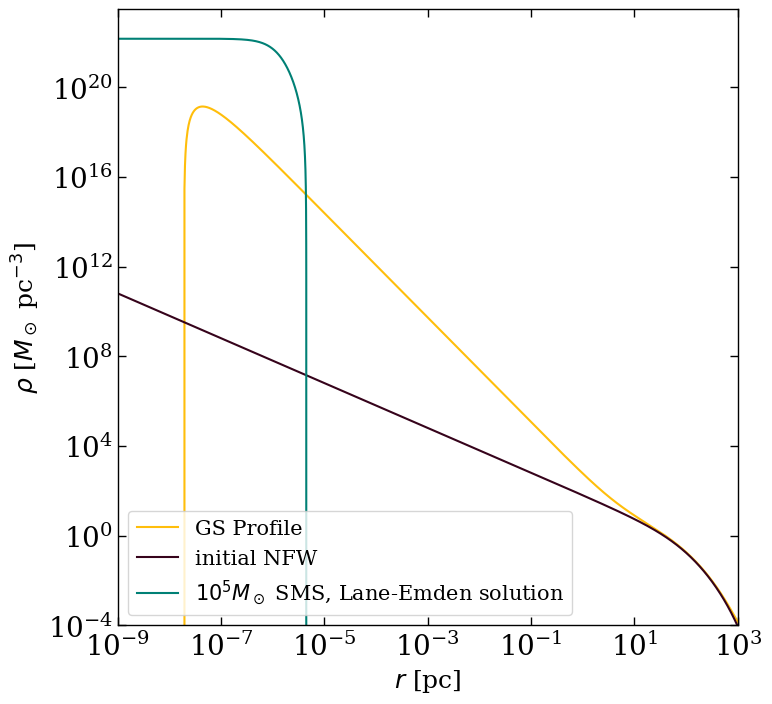

In [8]:
#Number of particles in the sample
#---------------------------------
N_particles = int(1.e7)


#Calculate adiabatic phase-space from scratch
#---------------------------------
FROM_SCRATCH = False


# BUILDING THE DM HALO PROFILE ************************************

R_s = R_vir/c
a_NFW = np.log(1 + c) - c/(1 + c)
rho_halo = M_halo/(4/3 * np.pi * R_vir**3)
rho_0_prime = rho_halo*c**3/(3*a_NFW)

def rho_NFW(r):
    return rho_0_prime * (R_s/r) / (1 + r/R_s)**2 * np.exp(-r/R_vir)

# ******************************************************************

# BUILDING THE SMS PROFILE ************************************

M_tot = 1E5 # M_sun   # MASS OF THE SMS

m_proto = M_tot
n = 3
rho_c = 1. * (3.0857E18)**3 / (1.9885E33) # M_sun/pc^3
poly_solver = PolytropicSolver(n)
r_array_poly, rho_array_poly = poly_solver(rho_c, m_proto)
rho_proto_poly_interp = interp1d(r_array_poly, rho_array_poly, fill_value = (rho_array_poly[0], 0), bounds_error = False)
r_poly = np.min(r_array_poly[rho_array_poly <= 0])
print("r_poly:", r_poly)
r_core = 5E-7

################################################################

m_BH = M_tot
r_S = 2*G_N*m_BH/c_light**2
def psi_BH(r):
    return G_N*m_BH/r

#r_sp = 0.122 * R_s * ( m_BH / ( rho_0_prime * R_s**3 ) )**(1./(3.-1))

# BUILDING THE GS PROFILE ************************************

gamma_PL = 1.
r_0   = R_s
rho_0 = rho_0_prime/4.
gamma_sp_GS = (9. - 2.*gamma_PL)/(4. - gamma_PL)

alpha_gamma = 0.293 * (gamma_PL)**(4./9.)

def g_GS(r):
    #return (1. - 2.*r_S/r)
    return (1. - 2.*r_S/r)**3.

r_sp_GS = alpha_gamma * r_0 * (m_BH / (rho_0 * r_0**3.))**(1./(3. - gamma_PL))

print(">------- NOTE THAT WE'RE USING A FACTOR OF 2 TO FUDGE THE RESULTS: CHECK WHERE IT COMES FROM!")
rho_R = 0.5*rho_0*(r_sp_GS/r_0)**(-gamma_PL)

def rho_GS(r):
    return rho_0_prime * (R_s/r) / (1 + r/R_s)**2 * np.exp(-r/R_vir) + g_GS(r) * rho_R*(r_sp_GS/r)**(gamma_sp_GS)

rho_GS_array = rho_GS(r_array)

################################################################

#input("Press Enter to continue...")

print("> Creating Density objects...")

N_part = int(1e2) #
density_NFW = Density('density_NFW_SMS', rho_NFW, r_array, N_particles = N_part)
density_NFW.setup_potentials()
psi_NFW = density_NFW.get_psi()
M_tot_NFW = density_NFW.M_enclosed(r_array[-1])
rho_initial = density_NFW(r_array)

print("> ...Done.")

density_proto_poly = Density('density_proto_poly', rho_proto_poly_interp, r_array, N_particles = int(5E0))
density_proto_poly.setup_potentials()
psi_proto_poly = density_proto_poly.get_psi()
M_tot_proto_poly = density_proto_poly.M_enclosed(r_array[-1])

print("> ...Done.")

print("> Creating FIGURE 1...")

plt.figure(figsize=(8,8))
plt.loglog(r_array, rho_GS_array, c = rgb_palette_dict['amber'], label = 'GS Profile')
plt.loglog(r_array, rho_NFW(r_array), c = rgb_palette_dict['dark sienna'], label = 'initial NFW')
plt.loglog(r_array_poly, rho_proto_poly_interp(r_array_poly), c = rgb_palette_dict['pine green'], label = r'$10^5 M_\odot$ SMS, Lane-Emden solution')
plt.xlim(1E-9, 1E3)
plt.ylim(bottom = 1E-4)
plt.xlabel(r'$r$ [pc]')
plt.ylabel(r'$\rho$ [$M_\odot$ pc$^{-3}$]')
plt.legend(fontsize=15)
plt.savefig('./figures/density_NFW_gas_star_densities.pdf')



"""
rho_0_gas_i = 1E-23 * (3.0857E18)**3 / (1.9885E33) # M_sun/pc^3
r_c_i = 1E1
def rho_gas_initial(r):
    return rho_0_gas_i / (1 + r/r_c_i)**2

rho_0_gas_f = 1E-15 * (3.0857E18)**3 / (1.9885E33) # M_sun/pc^3
r_c_f = 1E-3
def rho_gas_final(r):
    return rho_0_gas_f / (1 + r/r_c_f)**2

plt.figure()
plt.loglog(r_array, rho_NFW(r_array), c = rgb_palette_dict['rich black'])
plt.loglog(r_array, rho_gas_initial(r_array), c = rgb_palette_dict['pine green'])
plt.loglog(r_array, rho_gas_final(r_array), c = rgb_palette_dict['turquiose'])
plt.ylim(bottom = 1E-4)
#plt.show()

#rho_M_data = np.genfromtxt('/Users/daniele/Dropbox/Fisica/2023/EvolvingDensities-main/rho_M.csv', delimiter = ',')
rho_M_data = np.genfromtxt('rho_M.csv', delimiter = ',')
logrho_M_interp = interp1d(rho_M_data[:, 0], np.log10(rho_M_data[:, 1]), kind = 'quadratic', bounds_error = False,
                           fill_value = (np.log10(rho_M_data[0, 1]), 0))
rho_M_interp = lambda x: 10**logrho_M_interp(x) * (3.0857E18)**3 / (1.9885E33)
x_test = np.linspace(0, np.max(rho_M_data[:, 0]), num = 1000)
x_test = np.append(x_test, np.max(rho_M_data[:, 0]) - np.logspace(-8, -1, num = 1000))
x_test = np.unique(x_test)
r_reconstructed = [0]
for i in range(len(x_test) - 1):
    dM = (x_test[i + 1] - x_test[i]) * M_tot # M_sun
    rho = (rho_M_interp(x_test[i]) + rho_M_interp(x_test[i + 1]))/2 
    r = r_reconstructed[-1]
    dr = np.cbrt(3*dM/(4*np.pi*rho) + r**3) - r
    r_reconstructed.append(r + dr)
    #if i%100 == 0: print(r_reconstructed[-1], dr)
r_reconstructed = np.array(r_reconstructed)
rho_SMS_bloated_interp = interp1d(np.array(r_reconstructed), rho_M_interp(x_test), fill_value = (rho_M_interp(x_test[0]), 0), bounds_error = False)

#%%
plt.figure()
plt.loglog(r_array, psi_NFW(r_array), c = rgb_palette_dict['dark sienna'], label = 'initial NFW')
plt.loglog(r_array, psi_gas_i(r_array), c = rgb_palette_dict['pine green'], label = 'initial gas cloud')
plt.loglog(r_array, psi_gas_f(r_array), c = rgb_palette_dict['turquiose'], label = 'collapsed gas cloud')
plt.loglog(r_array, psi_SMS_bloated(r_array), c = rgb_palette_dict['flickr pink'], label = r'$10^5 M_\odot$ SMS')
plt.loglog(r_array, psi_proto_poly(r_array), c = 'C0', label = r'$10^5 M_\odot$ Polytrope')
plt.xlim(1E-9, 1E3)
plt.legend()
plt.xlabel('$r$ (pc)')
plt.ylabel(r'$\psi$')
plt.savefig('./figures/density_NFW_gas_star_potentials.pdf')
#plt.show()

density_gas_initial = Density('density_gas_initial', rho_gas_initial, r_array, N_particles = int(5E0))
density_gas_initial.setup_potentials()
psi_gas_i = density_gas_initial.get_psi()
M_tot_gas_i = density_gas_initial.M_enclosed(r_array[-1])

density_gas_final = Density('density_gas_final', rho_gas_final, r_array, N_particles = int(5E0))
density_gas_final.setup_potentials()
psi_gas_f = density_gas_final.get_psi()
M_tot_gas_f = density_gas_final.M_enclosed(r_array[-1])

density_SMS_bloated = Density('density_SMS_bloated', rho_SMS_bloated_interp, r_array, N_particles = int(5E0))
#density_SMS_bloated.smoothen_density()
density_SMS_bloated.setup_potentials()
psi_SMS_bloated = density_SMS_bloated.get_psi()
M_tot_SMS_bloated = density_SMS_bloated.M_enclosed(r_array[-1])
"""

In [3]:
print("> Supermassive star formation...")

if ((FROM_SCRATCH) or (not os.path.isfile("f_grid.npy"))):
    print("> Calling Adiabatic Growth...")
    #BJK: Use refinement=15
    #######################################################################################################################
    #######################################################################################################################
    #######################################################################################################################
    density_after_SMS, E_grid, L_grid, f_grid = density_NFW.adiabatic_growth(psi_proto_poly, refinement = 15, figures = False, return_DF=True)
    #######################################################################################################################
    #######################################################################################################################
    #######################################################################################################################

    rho_array = density_after_SMS(r_array)

    np.save("r_array.npy", r_array)
    np.save("rho_array.npy", rho_array)
    np.save("E_grid.npy", E_grid)
    np.save("L_grid.npy", L_grid)
    np.save("f_grid.npy", f_grid)
    
    _psi = psi_NFW(r_array) + psi_proto_poly(r_array)
    
    T_orb_grid = 0.0*f_grid
    for i, E in enumerate(tqdm(E_grid[:,0])):
        for j, L in enumerate(L_grid[0,:]):
            vr_sq_grid = 2*_psi - 2*E - L**2/r_array**2
            inds = vr_sq_grid > 0
            
            if ((np.sum(inds) > 0) and (np.sum(inds) < 100)):
                _r = np.geomspace(np.min(r_array[inds]), np.max(r_array[inds]), 250)
                _psi_new = psi_NFW(_r) + psi_proto_poly(_r)
                vr_sq_grid = 2*_psi_new - 2*E - L**2/_r**2
                inds = vr_sq_grid > 0
            
                integ = 0.0*vr_sq_grid
                integ[inds] = 1/np.sqrt(vr_sq_grid[inds])
                T_orb_grid[i,j] = np.trapz(integ, _r, axis=-1)
            else:
                integ = 0.0*vr_sq_grid
                integ[inds] = 1/np.sqrt(vr_sq_grid[inds])
                T_orb_grid[i,j] = np.trapz(integ, r_array, axis=-1)

    np.save("T_orb_grid.npy", T_orb_grid)

else:
    print("> Loading grids from file...")
    r_array   = np.load("r_array.npy")
    rho_array = np.load("rho_array.npy")
    E_grid    = np.load("E_grid.npy")
    L_grid    = np.load("L_grid.npy")
    f_grid    = np.load("f_grid.npy")
    
    T_orb_grid    = np.load("T_orb_grid.npy")

print(f_grid.flags)

f_grid[np.isnan(f_grid)] = 0.0

> Supermassive star formation...
> Loading grids from file...
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



In [4]:
def lin_sampler(x_min, x_max, N):
    u = np.random.rand(N)
    x = (x_max - x_min)*u + x_min
    return x

def log_sampler(x_min, x_max, N):
    return np.exp(lin_sampler(np.log(x_min), np.log(x_max), N))

#Sampling E, L points
#--------------------

print("let's start")

Lmin = 1e-8

E_samps = lin_sampler(np.min(E_grid[:,0]), np.max(E_grid[:,0]), N_particles)
L_samps = log_sampler(Lmin, np.max(L_grid[0,:]), N_particles)

deltaE = np.max(E_grid[:,0]) - np.min(E_grid[:,0])
deltaL = np.max(L_grid[0,:]) - Lmin

deltalogE = np.log(np.max(E_grid[:,0])) - np.log(np.min(E_grid[:,0]))
deltalogL = np.log(np.max(L_grid[0,:])) - np.log(Lmin)

_psi = psi_NFW(r_array) + psi_proto_poly(r_array)

print("Shapes")
print(E_grid.shape)
print(L_grid.shape)
print(T_orb_grid.shape)
print(f_grid.shape)

points = (E_grid[:,0], L_grid[0,:])
#new_points = np.array((E_samps, L_samps)).T
new_points = (E_samps, L_samps)


print("Running interpn")

f_E_L = interpn(points,  (4*np.pi)**2*(L_grid*T_orb_grid)*f_grid, new_points, bounds_error=False, fill_value=0.0)

p_samps = 1/(L_samps)
#p_samps = 1/(E_samps*L_samps)
#p_samps = 1.0
weights = (1/p_samps)*f_E_L

Vol = deltaE*deltalogL

print("Total:", Vol*np.sum(weights)/N_particles/M_halo)

_psi = psi_NFW(r_array) + psi_proto_poly(r_array)

# Reconstructing Density Profile
#-------------------------------

T_orb_samps = 0.0*E_samps
P_r_A = 0.0*r_array

for i in tqdm(range(N_particles),desc="Calculating density profile"):
    
    if (weights[i] > 0):
        E = E_samps[i]
        L = L_samps[i]
        vr_sq_grid = 2*_psi - 2*E - L**2/r_array**2
        inds = vr_sq_grid > 0
        integ = 0.0*vr_sq_grid
        
        if ((np.sum(inds) > 0) and (np.sum(inds) < 100)):
            _r = np.geomspace(np.min(r_array[inds]), np.max(r_array[inds]), 250)
            _psi_new = psi_NFW(_r) + psi_proto_poly(_r)
            vr_sq_grid = 2*_psi_new - 2*E - L**2/_r**2
            inds = vr_sq_grid > 0
        
            integ = 0.0*vr_sq_grid
            integ[inds] = 1/np.sqrt(vr_sq_grid[inds])
            T_orb_samps[i] = np.trapz(integ, _r, axis=-1)
            
            integ2 = np.interp(r_array, _r, integ, left=0.0, right=0.0)
            
        else:
            integ = 0.0*vr_sq_grid
            integ[inds] = 1/np.sqrt(vr_sq_grid[inds])
            T_orb_samps[i] = np.trapz(integ, r_array, axis=-1)
            integ2 = 1.0*integ
        
        if (T_orb_samps[i] > 0):
            P_r_A += (Vol/N_particles)*weights[i]*integ2/T_orb_samps[i]
        
#P_r_A = (Vol/N_particles)*np.sum(weights[:,np.newaxis]*integ/T_orb_samps[:,np.newaxis], axis=0)

rho_r_A = P_r_A/(4*np.pi*r_array**2)


#Sampling r-positions
#--------------------

r_samps = 0.0*E_samps

psi_fun = lambda x: psi_NFW(x) + psi_proto_poly(x)
for i in tqdm(range(N_particles)):
    found = False
    if (weights[i] < 1e-20):
        r_samps[i] = 1.0
        continue
        
    _Nr = 1000
    while not found:
        _rs = log_sampler(np.min(r_array), np.max(r_array), _Nr)
        vr_sq = 2*psi_fun(_rs) - 2*E_samps[i] - L_samps[i]**2/_rs**2
        inds = vr_sq > 0
        #print(inds)
        if np.sum(inds) > 0:
            found = True
        else:
            _Nr *= 10
        #print(weights[i])
        if (_Nr > 10000):
            r_samps[i] = 1.0
            weights[i] = 0.0
            found = True
        #assert(_Nr < 100000)
        
    #assert(np.sum(inds) > 0)
    
    if (np.sum(inds) == 0):
        continue
    
    i1 = np.random.choice(np.arange(len(_rs))[inds])
    r_samps[i] = _rs[i1]
    if (T_orb_samps[i] > 0):
        weights[i] *= (_rs[i1]/np.sqrt(vr_sq[i1]))/T_orb_samps[i]
    else:
        weights[i] = 0
    
#Instantaneous BH formation
#--------------------------

E_f_samps = E_samps - psi_proto_poly(r_samps) + psi_BH(r_samps)

_psi = psi_NFW(r_array) + psi_BH(r_array)

T_orb_samps_B = 0.0*E_samps
P_r_B = 0.0*r_array
P_r_C = 0.0*r_array

#Reconstructing density profile
#------------------------------

#def L_c(E):
#    E2 = 1 - E/c_light**2
#    return np.sqrt(32*(G_N*m_BH/c_light)**2/(36*E2**2 - 27*E2**4 - 8 + E2*(9*E2**2 - 8)**(3/2)))

for i in tqdm(range(N_particles),desc="Calculating density profile"):
    #_psi = psi_NFW(_r1) + psi_SMS_bloated(_r1)
    if (weights[i] > 0):
        E = E_f_samps[i]
        L = L_samps[i]
        vr_sq_grid = 2*_psi - 2*E - L**2/r_array**2
        inds = vr_sq_grid > 0
        integ = 0.0*vr_sq_grid
        if ((np.sum(inds) > 0) and (np.sum(inds) < 100)):
            _r = np.geomspace(np.min(r_array[inds]), np.max(r_array[inds]), 250)
            _psi_new = psi_NFW(_r) + psi_BH(_r)
            vr_sq_grid = 2*_psi_new - 2*E - L**2/_r**2
            inds = vr_sq_grid > 0
        
            integ = 0.0*vr_sq_grid
            integ[inds] = 1/np.sqrt(vr_sq_grid[inds])
            T_orb_samps_B[i] = np.trapz(integ, _r, axis=-1)
            
            integ2 = np.interp(r_array, _r, integ, left=0.0, right=0.0)
            r_peri = np.min(_r[inds])
            
        else:
            integ = 0.0*vr_sq_grid
            integ[inds] = 1/np.sqrt(vr_sq_grid[inds])
            T_orb_samps_B[i] = np.trapz(integ, r_array, axis=-1)
            integ2 = 1.0*integ
            r_peri = np.min(r_array[inds])
        
        
        if (T_orb_samps_B[i] > 0):
            contrib = (Vol/N_particles)*weights[i]*integ2/T_orb_samps_B[i]
            P_r_B += contrib
            #if (L > L_c(E)):
            if (r_peri > 2*r_S):
                P_r_C += contrib

rho_r_B = P_r_B/(4*np.pi*r_array**2)
rho_r_C = P_r_C/(4*np.pi*r_array**2)

let's start
Shapes
(3978, 2000)
(3978, 2000)
(3978, 2000)
(3978, 2000)
Running interpn
Total: 0.2678293423220258


Calculating density profile: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10000000/10000000 [05:42<00:00, 29206.49it/s]


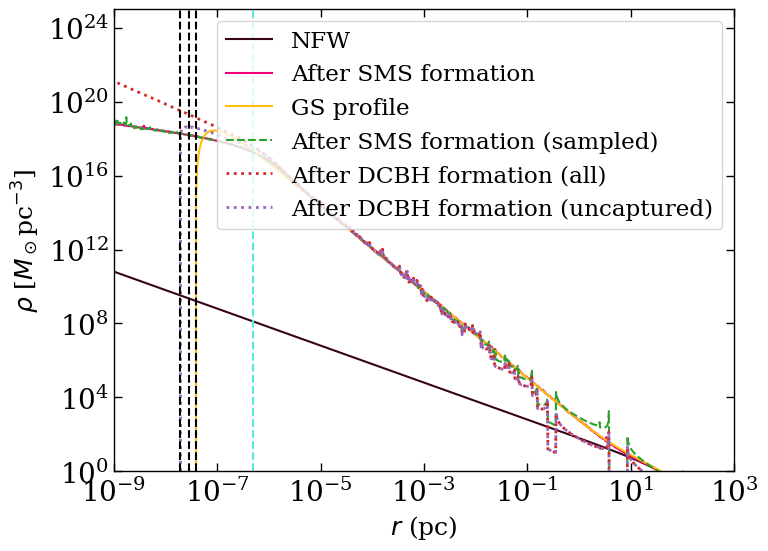

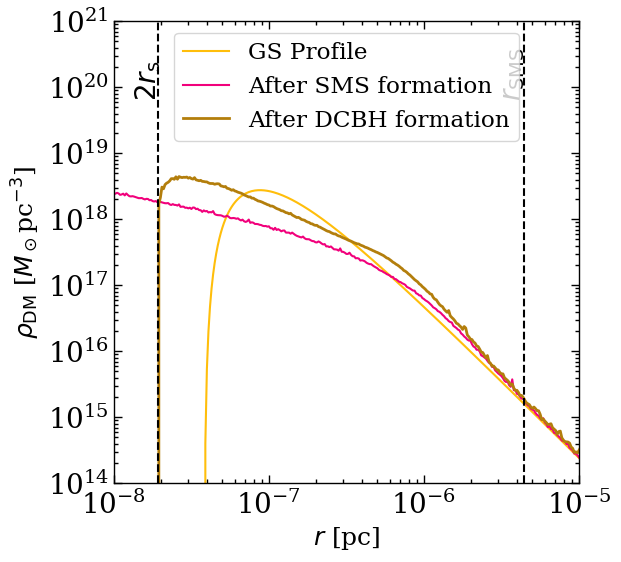

In [5]:
"""
#--------------------

plt.figure()

plt.loglog(r_array, rho_initial, c = rgb_palette_dict['dark sienna'], label = 'NFW')
#plt.loglog(r_array, rho_GS_no_r_S, c = rgb_palette_dict['amber'], label = r'GS, $m_{BH} = 10^5 M\odot$') #density_GS_pred
# plt.loglog(r_array, rho_after_proto, c = rgb_palette_dict['purple pizzazz'], label = 'after isothermal collapse')
plt.loglog(r_array, rho_array, c = rgb_palette_dict['flickr pink'], label = 'After SMS formation')
plt.loglog(r_array, rho_GS_array, c = rgb_palette_dict['amber'], label = 'GS profile')
#plt.loglog(r_array, rho_r,c='C1', linestyle=':')
plt.loglog(r_array, rho_r_A,c='C2', linestyle='--', label="After SMS formation (sampled)")
plt.loglog(r_array, rho_r_B,c='C3', linestyle=':',lw=2, label="After DCBH formation (all)")
plt.loglog(r_array, rho_r_C,c='C4', linestyle=':',lw=2, label="After DCBH formation (uncaptured)")
plt.axvline(r_core, c = rgb_palette_dict['turquiose'], ls = '--')
plt.axvline(2*r_S, c = 'k', ls = '--')
plt.axvline(3*r_S, c = 'k', ls = '--')
plt.axvline(4*r_S, c = 'k', ls = '--')
plt.ylim(1E0, 1E25)
plt.xlim(1E-9, 1E3)
plt.legend()
plt.ylabel(r'$\rho$ [$M_\odot$pc$^{-3}$]')
plt.xlabel(r'$r$ (pc)')
plt.savefig('./figures/density_NFW_rho_SMS.pdf')


plt.figure(figsize=(6,6))
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))
plt.loglog(r_array, rho_GS_array, c = rgb_palette_dict['amber'], label = 'GS Profile')
plt.loglog(r_array, rho_array, c = rgb_palette_dict['flickr pink'], label = 'After SMS formation')
plt.loglog(r_array, rho_r_C, c=rgb_palette_dict['dark goldenrod'], linestyle='-',lw=2, label="After DCBH formation")
plt.axvline(2*r_S, c = 'k', ls = '--')
plt.axvline(r_poly, c = 'k', ls = '--')
plt.text(1.4*r_S, 8e19, r"$2 r_\mathrm{s}$", rotation=90)
plt.text(0.7*r_poly, 8e19, r"$r_\mathrm{SMS}$", rotation=90)
plt.ylim(1E14, 1E21)
plt.xlim(1E-8, 1E-5)
plt.legend()
plt.ylabel(r'$\rho_\mathrm{DM}$ [$M_\odot$pc$^{-3}$]')
plt.xlabel(r'$r$ [pc]')
plt.savefig('./figures/density_NFW_rho_SMS_zoom.pdf')
plt.show()
"""


/usr/local/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


[8.70963590e-08 3.46736850e-07 1.38038426e-06 5.49540874e-06
 2.18776162e-05]
0
[-16.94702628 -16.92400043 -16.90097458 -16.87794873 -16.85492288
 -16.83189703 -16.80887118 -16.78584533 -16.76281948 -16.73979363
 -16.71676778 -16.69374192 -16.67071607 -16.64769022 -16.62466437
 -16.60163852 -16.57861267 -16.55558682 -16.53256097 -16.50953512
 -16.48650927 -16.46348341 -16.44045756 -16.41743171 -16.39440586
 -16.37138001 -16.34835416 -16.32532831 -16.30230246 -16.27927661
 -16.25625076 -16.23322491 -16.21019905 -16.1871732  -16.16414735
 -16.1411215  -16.11809565 -16.0950698  -16.07204395 -16.0490181
 -16.02599225 -16.0029664  -15.97994055 -15.95691469 -15.93388884
 -15.91086299 -15.88783714 -15.86481129 -15.84178544 -15.81875959
 -15.79573374 -15.77270789 -15.74968204 -15.72665619 -15.70363033
 -15.68060448 -15.65757863 -15.63455278 -15.61152693 -15.58850108]
[41.7330994  41.62879664 41.60311394 41.59233242 41.58932122 41.58525372
 41.56594635 41.53715287 41.54331882 41.57234196 41.536

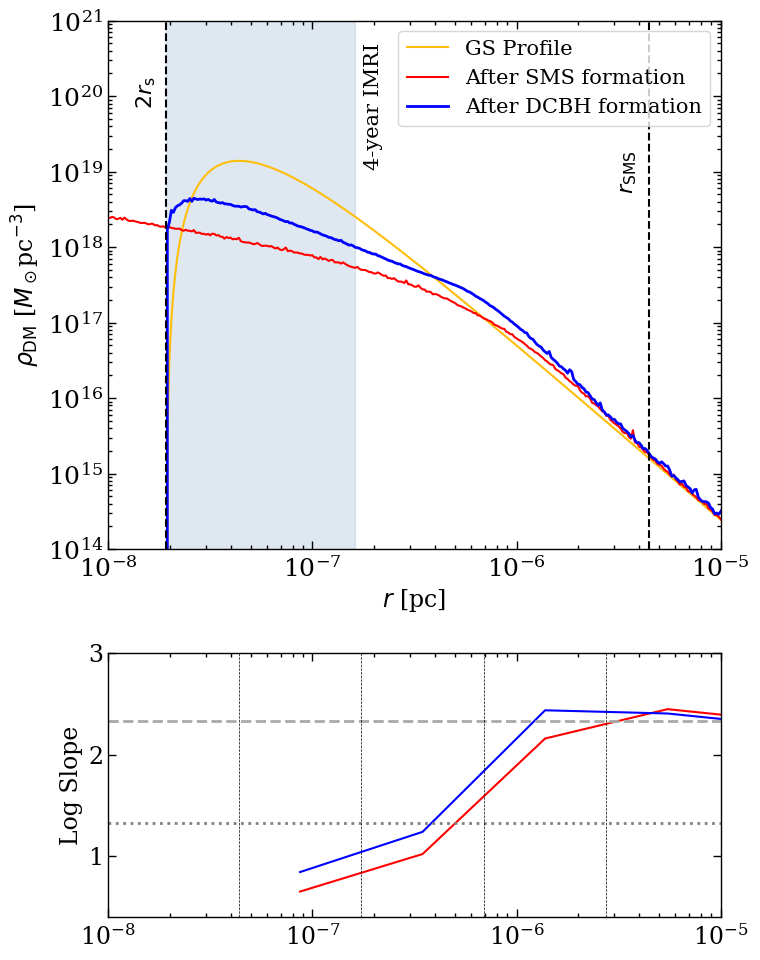

In [43]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

#
#rho_array_smooth  = savgol_filter(rho_array_cut, 10, 3)
#rho_r_C_smooth    = savgol_filter(rho_r_C_cut, 10, 3)
#
interval_start = 2*r_S
interval_end = 10*r_poly
#print(interval_start)
#print(interval_end)
indices_in_interval = np.where((r_array >= interval_start) & (r_array <= interval_end))[0]
small_value = 1.e15
#
rho_array_cut = np.zeros(len(r_array))
rho_r_C_cut = np.zeros(len(r_array))
#
rho_array_cut[:] = rho_array[:]
rho_r_C_cut[:]   = rho_r_C[:]
#print(rho_array_cut)
#
rho_array_cut[~np.isin(np.arange(len(r_array)), indices_in_interval)] = small_value
#
rho_array_smooth  = rho_array_cut   #savgol_filter(rho_array_cut, 30, 3)
#
rho_r_C_cut[~np.isin(np.arange(len(r_array)), indices_in_interval)] = small_value
#
rho_r_C_smooth  =  rho_r_C_cut # savgol_filter(rho_r_C_cut, 30, 3)
#
#print(rho_array)
#print(rho_array_cut)
#
spline_interpolation_rho = UnivariateSpline(r_array, np.log(rho_array_cut), s=3)
spline_interpolation_rC  = UnivariateSpline(r_array, np.log(rho_r_C_cut), s=3)
#
log_rho_interpolated   = spline_interpolation_rho(r_array)
log_r_C_interpolated   = spline_interpolation_rC(r_array)

##
"""
plt.figure()
plt.xlim(1E-8, 1E-5)
plt.loglog(r_array, log_rho_interpolated, c = rgb_palette_dict['flickr pink'], label = 'logRho1')
plt.loglog(r_array, np.log(np.abs(rho_array_smooth)), c = "red", ls="--", label = 'logRho1_smooth')
plt.loglog(r_array, log_r_C_interpolated, c = rgb_palette_dict['dark goldenrod'], label = 'logRho2')
plt.loglog(r_array, np.log(np.abs(rho_r_C_smooth)), c = "brown", ls="--", label = 'logRho2_smooth')
#plt.ylim(1E0, 1E25)
#plt.xlim(1E-9, 1E3)
#plt.legend()
plt.show()
"""
#####
#####
#####

#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))
fig = plt.figure(figsize=(8, 10))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

#ax1.set_aspect(1)

ax1.loglog(r_array, rho_GS_array, c = rgb_palette_dict['amber'], label = 'GS Profile')
ax1.loglog(r_array, rho_array, c = "red", label = 'After SMS formation')
#ax1.loglog(r_array, rho_array_smooth, c = "red", linestyle="--", label = 'After SMS formation')
ax1.loglog(r_array, rho_r_C, c = "blue", linestyle='-',lw=2, label="After DCBH formation")
#ax1.loglog(r_array, rho_r_C_smooth, c="brown", linestyle='--',lw=2, label="After DCBH formation")
ax1.axvline(2*r_S, c = 'k', ls = '--')
ax1.axvline(r_poly, c = 'k', ls = '--')
ax1.text(1.4*r_S, 8e19, r"$2 r_\mathrm{s}$", rotation=90, fontsize=16)
ax1.text(0.7*r_poly, 6e18, r"$r_\mathrm{SMS}$", rotation=90, fontsize=16)
ax1.set_ylim(1E14, 1E21)
ax1.set_xlim(1E-8, 1E-5)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.legend(fontsize=15)
ax1.set_ylabel(r'$\rho_\mathrm{DM}$ [$M_\odot$pc$^{-3}$]', fontsize = 17)
ax1.set_xlabel(r'$r$ [pc]', fontsize = 17)

xmin_emri = 2*r_S
xmax_emri = 1.62e-7
ax1.axvspan(xmin_emri, xmax_emri, color='lightsteelblue', alpha=0.4)  # Adjust alpha for transparency
ax1.text(1.8e-7, 1.2e19, r"4-year IMRI", rotation=90, fontsize=15)

# Bottom panel

interval_start_2 = 4.5*r_S
interval_end_2 = 10*r_poly
#print(interval_start_2)
#print(interval_end_2)
indices_in_interval_2 = np.where((r_array >= interval_start_2) & (r_array <= interval_end_2))[0]
#slope_1 = np.gradient(log_rho_interpolated, np.log(r_array))
#slope_2 = np.gradient(log_r_C_interpolated,   np.log(r_array))
slope_1 = np.gradient(np.log(np.abs(rho_array_smooth)), np.log(r_array))
slope_2 = np.gradient(np.log(np.abs(rho_r_C_smooth)),   np.log(r_array))
spline_slope_1 = UnivariateSpline(r_array, np.abs(slope_1), s=3)
spline_slope_2 = UnivariateSpline(r_array, np.abs(slope_2), s=3)
slope_1_interp = spline_slope_1(r_array)
slope_2_interp = spline_slope_2(r_array)
#
interval_start_ = interval_start_2 
interval_end_ = interval_end_2
indices_in_interval_ = np.where((r_array >= interval_start_) & (r_array <= interval_end_))[0]
#
slope_1_cut = np.abs(slope_1[:])
slope_1_cut[~np.isin(np.arange(len(r_array)), indices_in_interval_)] = 0.
slope_2_cut = np.abs(slope_2[:])
slope_2_cut[~np.isin(np.arange(len(r_array)), indices_in_interval_)] = 0.
#
slope_1_interp_cut = np.abs(slope_1_interp[:])
slope_1_interp_cut[~np.isin(np.arange(len(r_array)), indices_in_interval_)] = 0.
slope_2_interp_cut = np.abs(slope_2_interp[:])
slope_2_interp_cut[~np.isin(np.arange(len(r_array)), indices_in_interval_)] = 0.
#
slope_1[~np.isin(np.arange(len(r_array)), indices_in_interval_2)] = 0.01
slope_2[~np.isin(np.arange(len(r_array)), indices_in_interval_2)] = 0.01
#
# SLIDING WINDOW LogSlope fit
#
window_size = 30  # Size of the sliding window
slopes = []
positions = []  # Midpoints of windows for plotting
r_array_cut = r_array[indices_in_interval]
rho_array_smooth_cut = np.abs(rho_array[indices_in_interval])
#print(r_array_cut)
#print(rho_array_smooth_cut)

# Slide the window and compute slopes
for start in range(len(r_array_cut) - window_size + 1):
    end = start + window_size
    x_window = np.log(r_array_cut)[start:end].reshape(-1, 1)  # Reshape for sklearn
    y_window = np.log(rho_array_smooth_cut)[start:end] 
    #print("***", start)
    #print(x_window)
    #print(y_window)
    # Linear regression
    model = LinearRegression().fit(x_window, y_window)
    slopes.append(np.abs(model.coef_[0]))  # Collect slope
    #print("*** ", start)
    #print(model.coef_[0])
    positions.append(r_array_cut[start:end].mean())
#

def linearF(x, a, b):
    return a +  b*x

# Binned fit
Nbins = 5  # Number of bins
x_array = r_array[indices_in_interval_2]
y_array_1 = rho_array_smooth[indices_in_interval_2]
y_array_2 = rho_r_C_smooth[indices_in_interval_2]

bin_edges = np.logspace(np.log10(min(x_array)), np.log10(max(x_array)), Nbins + 1)
bin_centers = np.sqrt(bin_edges[:-1]*bin_edges[1:])
print(bin_centers)

fit_params_1 = []
fit_params_2 = []

for i in range(Nbins):
    bin_mask = (x_array >= bin_edges[i]) & (x_array < bin_edges[i + 1])
    x_bin = np.log(x_array[bin_mask])
    y_bin_1 = np.log(y_array_1[bin_mask])
    y_bin_2 = np.log(y_array_2[bin_mask])
    print(i)
    print(x_bin) 
    print(y_bin_1)
    popt_1, _ = curve_fit(linearF, x_bin, y_bin_1)
    popt_2, _ = curve_fit(linearF, x_bin, y_bin_2)
    print(popt_1[0])
    print(popt_1[1])
    fit_params_1.append(np.abs(popt_1[1]))
    fit_params_2.append(np.abs(popt_2[1]))
    
print(bin_centers)
print(fit_params_1)

#ax2.plot(bin_centers, fit_params_1, c="red", ls ="--")
#ax2.plot(bin_centers, fit_params_2, c="blue", ls ="--")

spline_interpolation_1 = UnivariateSpline(bin_centers, fit_params_1, s=3)
spline_interpolation_2  = UnivariateSpline(bin_centers, fit_params_2, s=3)

ax2.plot(bin_centers, spline_interpolation_1(bin_centers), c="red", ls ="-")
ax2.plot(bin_centers, spline_interpolation_2(bin_centers), c="blue", ls ="-")

#ax2.plot(r_array, slope_1_cut, c = "red", ls=":")
#ax2.plot(r_array, slope_1_interp_cut, c = "red", ls="-")
#ax2.plot(r_array, slope_2_cut, c = "blue", linestyle=':',lw=2)
#ax2.plot(r_array, slope_2_interp_cut, c = "blue", ls="-")
ax2.axhline(y=4/3., color="grey", linestyle=':', linewidth=2)
ax2.axhline(y=7/3., color="darkgrey", linestyle='--', linewidth=2)

for edge in bin_edges:
    plt.axvline(edge, color='black', linestyle='--', linewidth=0.5)

#ax2.plot(positions, slopes, color="blue", ls="-")
ax2.set_xscale("log")
ax2.set_ylabel("Log Slope", fontsize = 17)
ax2.set_xlim(1E-8, 1E-5)
ax2.set_ylim(4E-1, 3E0)
ax2.tick_params(axis='both', which='major', labelsize=17)
#
plt.tight_layout()
plt.savefig('./figures/density_NFW_rho_SMS_zoom_2_smooth.pdf')
plt.show()

